The purpose of this analysis is to study if the rate of inflation has any impact on the prices of gold and bitcoin.

We will use data from 5/13-7/21 to study the correlation between these variables 

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns 
sns.set()

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# import datasets

# https://www.kaggle.com/datasets/varpit94/us-inflation-data-updated-till-may-2021
inflation_import = pd.read_csv('/content/US CPI.csv')
# https://www.kaggle.com/datasets/saikumartamminana/gold-price-prediction
gold_import = pd.read_csv('/content/Gold (2).csv')
# https://www.kaggle.com/datasets/maharshipandya/-cryptocurrency-historical-prices-dataset 
crypto_import = pd.read_csv('/content/dataset.csv')

#Inflation data frame exploration and clean up

In [ ]:
inflation_df = inflation_import
inflation_df


,Yearmon,CPI,date2
0,1913-01-01,9.800,01/01/1913
1,1913-01-02,9.800,02/01/1913
2,1913-01-03,9.800,03/01/1913
3,1913-01-04,9.800,04/01/1913
4,1913-01-05,9.700,05/01/1913
...,...,...,...
1298,2021-01-03,264.877,03/01/2021
1299,2021-01-04,267.054,04/01/2021
1300,2021-01-05,269.195,05/01/2021
1301,2021-01-06,271.696,06/01/2021


In [ ]:
inflation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Yearmon  1303 non-null   object 
 1   CPI      1303 non-null   float64
dtypes: float64(1), object(1)
memory usage: 20.5+ KB


## observations
- The inflation report comes out once a month, so this dataset contains the monthly CPI values from 1/1/1913 - 7/1/2021
- There are no null values in this dataset
- The months are formatted as year-day-month
  - Will convert this to month/day/year

In [ ]:
# convert Yearmon column to datetime
inflation_df['Yearmon'] = pd.to_datetime(inflation_df.Yearmon)
# convert date format
inflation_df['date2'] = inflation_df['Yearmon'].dt.strftime('%d/%m/%Y')

inflation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Yearmon  1303 non-null   datetime64[ns]
 1   CPI      1303 non-null   float64       
 2   date2    1303 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 30.7+ KB


In [ ]:
#drop original Yearmon column
inflation_df_final = inflation_df.drop(['Yearmon'], axis = 1)
# rename new date column 
inflation_df_final.rename(columns = {"date2":"date"}, inplace = True)
#check
inflation_df_final.head()

,CPI,date
0,9.8,01/01/1913
1,9.8,02/01/1913
2,9.8,03/01/1913
3,9.8,04/01/1913
4,9.7,05/01/1913


# Crypto Import exploration and clean up

In [ ]:
# explore crypto_import
crypto_import['crypto_name'].value_counts()

Bitcoin                  3248
Litecoin                 3248
XRP                      3157
Dogecoin                 3024
Monero                   2866
Stellar                  2791
Tether                   2582
Ethereum                 2424
Ethereum Classic         2072
Basic Attention Token    1760
EOS                      1730
Bitcoin Cash             1708
BNB                      1706
TRON                     1656
Decentraland             1652
Chainlink                1649
Cardano                  1638
Maker                    1605
Filecoin                 1565
Theta Network            1530
Huobi Token              1513
Ravencoin                1478
Tezos                    1365
VeChain                  1332
Quant                    1325
USD Coin                 1266
Cronos                   1199
Wrapped Bitcoin          1152
Cosmos                   1109
Polygon                  1064
OKB                      1062
UNUS SED LEO             1041
Algorand                 1010
Chiliz    

In [ ]:
# create bitcoin filter
btc = crypto_import['crypto_name'] == 'Bitcoin'
#create bitcoin dataframe
btc_df = crypto_import.iloc[btc.values]
# check 
btc_df['crypto_name'].value_counts()

Bitcoin    3248
Name: crypto_name, dtype: int64

In [ ]:
# eliminate unecessary columns
btc_df.drop(["Unnamed: 0",'high','low','volume', 'marketCap', 'timestamp'], axis=1, inplace=True)

btc_df.head()

,open,close,crypto_name,date
0,112.900002,115.910004,Bitcoin,2013-05-05
2,115.980003,112.300003,Bitcoin,2013-05-06
4,112.250000,111.500000,Bitcoin,2013-05-07
7,109.599998,113.566002,Bitcoin,2013-05-08
9,113.199997,112.669998,Bitcoin,2013-05-09


In [ ]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3248 entries, 0 to 72912
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         3248 non-null   float64
 1   close        3248 non-null   float64
 2   crypto_name  3248 non-null   object 
 3   date         3248 non-null   object 
dtypes: float64(2), object(2)
memory usage: 126.9+ KB


## observations
- There are no null values in this dataset
- The date column will need to be adjusted in order to merge with the inflation_df
  - Currently we have daily prices
  - Will round date column down to the first of the month to match the inflation report

In [ ]:
#convert date column to datetime
btc_df['date'] = pd.to_datetime(btc_df.date)
#create new date column with new day format
btc_df['date2'] = btc_df['date'].dt.strftime('%m/01/%Y')
#check
btc_df.head()

,open,close,crypto_name,date,date2
0,112.900002,115.910004,Bitcoin,2013-05-05,05/01/2013
2,115.980003,112.300003,Bitcoin,2013-05-06,05/01/2013
4,112.250000,111.500000,Bitcoin,2013-05-07,05/01/2013
7,109.599998,113.566002,Bitcoin,2013-05-08,05/01/2013
9,113.199997,112.669998,Bitcoin,2013-05-09,05/01/2013


In [ ]:
#create final bitcoin dataframe
#remove uneccesary columns
btc_df_final = btc_df.drop(['date', 'crypto_name'], axis = 1)
#rename remaining columns
btc_df_final.rename(columns = {"date2":"date", "open":"btc_open", "close":"btc_close"}, inplace = True)
#check
btc_df_final.head()

,btc_open,btc_close,date
0,112.900002,115.910004,05/01/2013
2,115.980003,112.300003,05/01/2013
4,112.250000,111.500000,05/01/2013
7,109.599998,113.566002,05/01/2013
9,113.199997,112.669998,05/01/2013


# Gold Prices data frame exploration and clean up

In [ ]:
#gold 
gold_import.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/28/2022,1648.3,186519.0,1667.2,1670.9,1640.7
1,10/27/2022,1668.8,180599.0,1668.8,1674.8,1658.5
2,10/26/2022,1669.2,183453.0,1657.7,1679.4,1653.8
3,10/25/2022,1658.0,178706.0,1654.5,1666.8,1641.2
4,10/24/2022,1654.1,167448.0,1662.9,1675.5,1648.0


In [ ]:
#create dataframe
#remove uneccesary columns
gold_df = gold_import.drop(['Volume','High', 'Low'], axis = 1)
#check
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547 entries, 0 to 2546
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2547 non-null   object 
 1   Close/Last  2547 non-null   float64
 2   Open        2547 non-null   float64
dtypes: float64(2), object(1)
memory usage: 59.8+ KB


## Observations
- There are no null values in the data set
- The date column will need to be adjusted to merge with the previous dataframes

In [ ]:
#convert date column to datetime
gold_df['Date'] = pd.to_datetime(gold_df.Date)
#create new date column for merge
gold_df['date2'] = gold_df['Date'].dt.strftime('%m/01/%Y')
#check
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547 entries, 0 to 2546
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2547 non-null   datetime64[ns]
 1   Close/Last  2547 non-null   float64       
 2   Open        2547 non-null   float64       
 3   date2       2547 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 79.7+ KB


In [ ]:
gold_df.head()

,Date,Close/Last,Open,date2
0,2022-10-28,1648.3,1667.2,10/01/2022
1,2022-10-27,1668.8,1668.8,10/01/2022
2,2022-10-26,1669.2,1657.7,10/01/2022
3,2022-10-25,1658.0,1654.5,10/01/2022
4,2022-10-24,1654.1,1662.9,10/01/2022


In [ ]:
# create final gold dataframe
# remove old date column
gold_df_final = gold_df.drop(['Date'], axis = 1)
#rename columns
gold_df_final.rename(columns = {"date2":"date", "Open":"gold_open", "Close/Last":"gold_close"}, inplace = True)
#check
gold_df_final.head()

,gold_close,gold_open,date
0,1648.3,1667.2,10/01/2022
1,1668.8,1668.8,10/01/2022
2,1669.2,1657.7,10/01/2022
3,1658.0,1654.5,10/01/2022
4,1654.1,1662.9,10/01/2022


# Merge final dataframes

In [ ]:
#merge inflation, gold, and bitcoin dataframes
totals_df = inflation_df_final.merge(btc_df_final, on = 'date').merge(gold_df_final, on = 'date')
#check
totals_df.head().append(totals_df.tail())

,CPI,date,btc_open,btc_close,gold_close,gold_open
0,232.945,05/01/2013,112.900002,115.910004,1393.0,1412.9
1,232.945,05/01/2013,112.900002,115.910004,1412.0,1392.9
2,232.945,05/01/2013,112.900002,115.910004,1391.8,1380.9
3,232.945,05/01/2013,112.900002,115.910004,1379.7,1394.1
4,232.945,05/01/2013,112.900002,115.910004,1386.6,1386.6
63447,273.003,07/01/2021,42196.303887,41626.195676,1800.2,1803.8
63448,273.003,07/01/2021,42196.303887,41626.195676,1802.1,1797.0
63449,273.003,07/01/2021,42196.303887,41626.195676,1794.2,1787.5
63450,273.003,07/01/2021,42196.303887,41626.195676,1783.3,1777.5
63451,273.003,07/01/2021,42196.303887,41626.195676,1776.8,1770.8


In [ ]:
totals_df['date'].min()

'01/01/2014'

In [ ]:
totals_df['date'].max()

'12/01/2020'

In [ ]:
totals_df['date'] = totals_df['date'].astype('datetime64[ns]')
print(totals_df['date'].min())
print(totals_df['date'].max())

2013-05-01 00:00:00
2021-07-01 00:00:00


In [ ]:
totals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63452 entries, 0 to 63451
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CPI         63452 non-null  float64       
 1   date        63452 non-null  datetime64[ns]
 2   btc_open    63452 non-null  float64       
 3   btc_close   63452 non-null  float64       
 4   gold_close  63452 non-null  float64       
 5   gold_open   63452 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.4 MB


##observations
- There are no null values in the data set
- Now we can test our hypotheses using the pearon correlation

In [ ]:
totals_df.corr()

,CPI,btc_open,btc_close,gold_close,gold_open
CPI,1.000000,0.750862,0.750901,0.762696,0.761935
btc_open,0.750862,1.000000,0.998682,0.685403,0.685344
btc_close,0.750901,0.998682,1.000000,0.685949,0.685913
gold_close,0.762696,0.685403,0.685949,1.000000,0.998403
gold_open,0.761935,0.685344,0.685913,0.998403,1.000000


### hypothesis 1
- The null hypothesis is that there is no correlation between the price of gold and the rate of inflation as measured by CPI. 
- The alternative hypothesis is that there is a correlation between the price of gold and the rate of inflation as measured by CPI. 


In [ ]:
stats.pearsonr(totals_df['CPI'], totals_df['gold_open'])

(0.7619348766927403, 0.0)

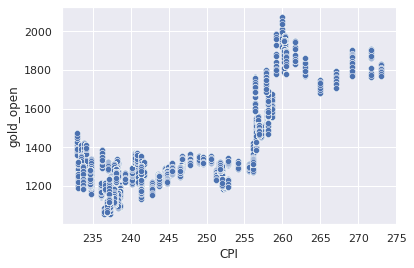

In [ ]:
sns.scatterplot(x="CPI", y="gold_open", data=totals_df);

#### h1 result
- The pearson correlation test shows a correlation coefficient of .76 with a p value <.05
- This rejects the null hypothesis and shows a strong positive correlation between the rate of inflation and the price of gold

### hypothesis 2
- The null hypothesis is that there is no correlation between the price of bitcoin and the rate of inflation as measured by CPI.
- The alternative hypothesis is that there is a correlation between the price of gold and the rate of inflation as measured by CPI.


In [ ]:
stats.pearsonr(totals_df['CPI'], totals_df['btc_open'])

(0.750861696955166, 0.0)

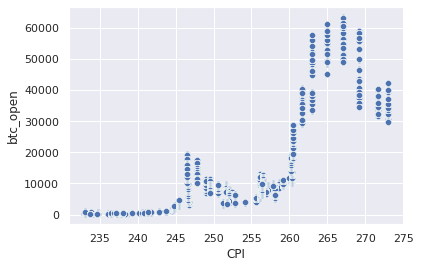

In [ ]:
sns.scatterplot(x="CPI", y="btc_open", data=totals_df);

#### h2 result
- The pearson correlation test shows a correlation coefficient of .75 with a p value <.05
- This rejects the null hypothesis and shows a strong positive correlation between the rate of inflation and the price of bitcoin


#Conclusion
- Our data suggests that the rate of inflation has a positive impact on the prices of gold and bitcoin

In [ ]:
totals_df['year'] = totals_df['date'].dt.year

totals_df

,CPI,date,btc_open,btc_close,gold_close,gold_open,year
0,232.945,2013-05-01,112.900002,115.910004,1393.0,1412.9,2013
1,232.945,2013-05-01,112.900002,115.910004,1412.0,1392.9,2013
2,232.945,2013-05-01,112.900002,115.910004,1391.8,1380.9,2013
3,232.945,2013-05-01,112.900002,115.910004,1379.7,1394.1,2013
4,232.945,2013-05-01,112.900002,115.910004,1386.6,1386.6,2013
...,...,...,...,...,...,...,...
63447,273.003,2021-07-01,42196.303887,41626.195676,1800.2,1803.8,2021
63448,273.003,2021-07-01,42196.303887,41626.195676,1802.1,1797.0,2021
63449,273.003,2021-07-01,42196.303887,41626.195676,1794.2,1787.5,2021
63450,273.003,2021-07-01,42196.303887,41626.195676,1783.3,1777.5,2021


In [ ]:
pivot = pd.pivot_table(totals_df, values=['CPI', 'btc_open', 'gold_open'], index=['year'],
                    aggfunc={'CPI': np.mean,
                             'btc_open': np.mean,
                             'gold_open': np.mean})

pivot



,CPI,btc_open,gold_open
year,,,
2013,233.470758,257.583840,1319.794707
2014,236.744685,528.222348,1265.633828
2015,237.040580,272.968740,1159.261052
2016,240.051237,568.409548,1251.081241
2017,245.135862,3953.546205,1260.096114
2018,251.146356,7598.357837,1271.345719
2019,255.699336,7421.978919,1396.611881
2020,258.818755,11018.795230,1778.880900
2021,267.305885,44585.558804,1805.627112


In [ ]:
melt = pd.read_csv('/content/melted.csv')

melt

,year,index,rate,change
0,2013,CPI,233.470758,0.000000
1,2013,btc_open,257.583840,0.000000
2,2013,gold_open,1319.794707,0.000000
3,2014,CPI,236.744685,-1.402286
4,2014,btc_open,528.222348,-105.068124
5,2014,gold_open,1265.633828,4.103735
6,2015,CPI,237.040580,-0.124985
7,2015,btc_open,272.968740,48.323137
8,2015,gold_open,1159.261052,8.404704
9,2016,CPI,240.051237,-1.270102


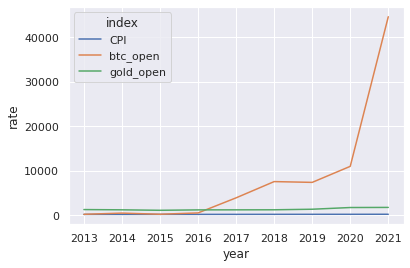

In [ ]:
sns.lineplot(x = "year", y = "rate", hue = "index", data = melt);

In [ ]:
totals_df

,CPI,date,btc_open,btc_close,gold_close,gold_open,year
0,232.945,2013-05-01,112.900002,115.910004,1393.0,1412.9,2013
1,232.945,2013-05-01,112.900002,115.910004,1412.0,1392.9,2013
2,232.945,2013-05-01,112.900002,115.910004,1391.8,1380.9,2013
3,232.945,2013-05-01,112.900002,115.910004,1379.7,1394.1,2013
4,232.945,2013-05-01,112.900002,115.910004,1386.6,1386.6,2013
...,...,...,...,...,...,...,...
63447,273.003,2021-07-01,42196.303887,41626.195676,1800.2,1803.8,2021
63448,273.003,2021-07-01,42196.303887,41626.195676,1802.1,1797.0,2021
63449,273.003,2021-07-01,42196.303887,41626.195676,1794.2,1787.5,2021
63450,273.003,2021-07-01,42196.303887,41626.195676,1783.3,1777.5,2021


In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
totals_df.to_csv('/content/drive/My Drive/python_for_data_analysts/totals_df.csv')